# Import libraries & data upload

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from keras import layers, Sequential, Input


In [2]:
df = pd.read_csv(r"cleaned_real_estate_data.csv")
df.head()

,Year,Sale Price,Residential,Month,Quarter,rooms_per_bathroom,price_per_sqft,price_to_estimated_ratio,value_area_interaction,rooms_area_interaction,...,Locality_Unknown,Locality_Waterbury,Locality_West Hartford,Property_Four Family,Property_Single Family,Property_Three Family,Property_Two Family,Face_North,Face_South,Face_West
0,2009,185000.0,1,1,1,1.0,185.742972,1.660086,1.109942e+08,2988.0,...,0,1,0,0,1,0,0,0,1,0
1,2009,152000.0,1,1,1,3.0,162.566845,2.079912,6.832980e+07,2805.0,...,1,0,0,0,1,0,0,1,0,0
2,2009,105000.0,1,1,1,3.0,110.410095,2.077562,4.806354e+07,2853.0,...,0,1,0,0,1,0,0,0,0,0
3,2009,1000000.0,1,1,1,1.5,1001.001001,1.751129,5.704889e+08,2997.0,...,0,0,0,0,1,0,0,0,1,0
4,2009,272900.0,1,1,1,3.0,281.050463,0.324405,8.168355e+08,2913.0,...,0,0,0,0,1,0,0,0,0,0


# Train-test split

In [3]:
# Define target and features
X = df.drop('Sale Price', axis=1)
y = df['Sale Price']

# Split 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (7996, 25)
Testing set shape: (2000, 25)


# Model building

### Linear models

In [4]:
# Linear Regression
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=1),
    LinearRegression()
)

lin_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')
print(lin_scores, lin_scores.mean())

[0.99601814 0.9904446  0.99582893 0.9964744  0.9961495 ] 0.9949831151705897


In [5]:
# Ridge Regression
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=1),
    Ridge(alpha=1.0, random_state=42)
)

ridge_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')
print(ridge_scores, ridge_scores.mean())

[0.99601848 0.99029096 0.99583497 0.99647901 0.99614833] 0.9949543490791601


In [6]:
# Lasso Regression
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=1),
    Lasso(alpha=0.001, max_iter=10000, random_state=42)
)

lasso_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')
print(lasso_scores, lasso_scores.mean())

[0.99601814 0.9904446  0.99582893 0.9964744  0.9961495 ] 0.9949831150992601


In [7]:
# ElasticNet Regression
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=1),
    ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000, random_state=42)
)

elasticnet_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')
print(elasticnet_scores, elasticnet_scores.mean())

[0.99601785 0.9899481  0.99584688 0.99648833 0.99614462] 0.9948891566828962


### Tree-Based Ensemble Models

In [8]:
# Decision Tree Regressor
pipe = make_pipeline(
    DecisionTreeRegressor(max_depth=None, random_state=42)
)

dt_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')
print(dt_scores, dt_scores.mean())

[0.99952975 0.99917153 0.99934149 0.99943487 0.99955399] 0.9994063260183006


In [9]:
# Random Forest Regressor
pipe = make_pipeline(
    RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
)

rf_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')
print(rf_scores, rf_scores.mean())

[0.99980463 0.99956411 0.99971113 0.99973024 0.99984732] 0.9997314877278614


In [10]:
# Gradient Boosting Regressor
pipe = make_pipeline(
    GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
)

GB_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')
print(GB_scores, GB_scores.mean())

[0.99976738 0.99970149 0.99971788 0.99971687 0.99971996] 0.9997247154709017


In [11]:
# XGBoost Regressor
pipe = make_pipeline(
    XGBRegressor(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
)

XGBoost_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')
print(XGBoost_scores, XGBoost_scores.mean())

[0.99976707 0.9996932  0.99972531 0.99970832 0.99972386] 0.9997235533301712


### Support Vector Regression (SVR)

In [12]:
svr_pipe = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=100, gamma='scale'))
svr_scores = cross_val_score(svr_pipe, X_train, y_train, cv=5, scoring="r2")
print(svr_scores, svr_scores.mean())

[ 0.0050659   0.01374314 -0.01097747 -0.01192574 -0.01314442] -0.003447717521189908


### KNN

In [13]:
knn_pipe = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=5))
knn_scores = cross_val_score(knn_pipe, X_train, y_train, cv=5, scoring="r2")
print(knn_scores, knn_scores.mean())

[0.90411056 0.88573464 0.89423989 0.90437499 0.89043708] 0.8957794324806414


Several regression models were trained to predict Sale Price, including both linear and tree-based models. The linear models — Linear Regression, Ridge, Lasso, and ElasticNet — performed well, achieving R² scores around 0.995, indicating strong linear relationships with the target.

Tree-based models such as Decision Tree, Random Forest, Gradient Boosting, and XGBoost performed even better, capturing complex patterns and non-linear interactions. Among them, Random Forest achieved the highest R² score of 0.9997, showing excellent predictive power and stability.

Models like SVR and KNN performed poorly, making them less suitable for this task.

Overall, Random Forest was selected as the best-performing model for further tuning and evaluation.

## Hyperparameter Tuning

In [18]:
rf = RandomForestRegressor(random_state=42)
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

# Best parameters and performance
print("Best Parameters:", random_search.best_params_)
print("Best CV R2 Score:", random_search.best_score_)

# Evaluate on test data
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("\nTest R2:", r2_score(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
Best CV R2 Score: 0.9966273079161839

Test R2: 0.9972366363491474
Test RMSE: 20920.344099562873


## Error Analysis

Model Performance:
R² Score: 0.997
MAE: 10278.282
RMSE: 20920.344


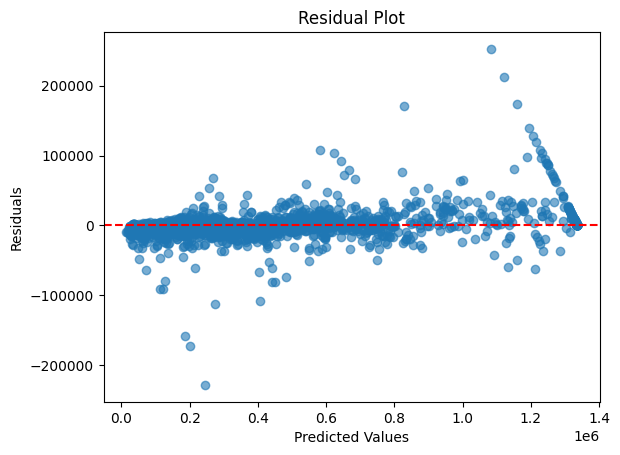

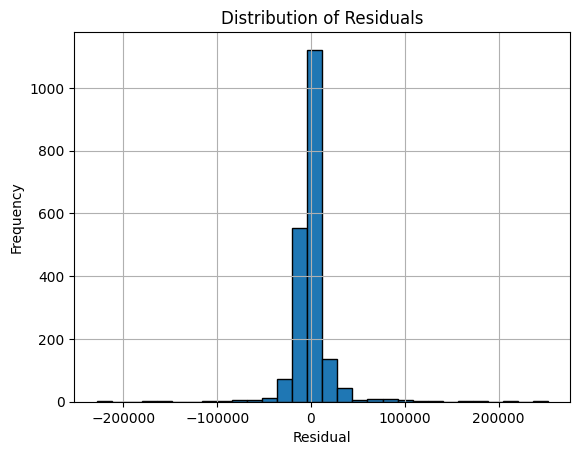

In [ ]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results['Residual'] = results['Actual'] - results['Predicted']

# error metrics
print("Model Performance:")
print("R² Score:", round(r2_score(y_test, y_pred), 3))
print("MAE:", round(mean_absolute_error(y_test, y_pred), 3))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 3))

# Residual plot
plt.scatter(results['Predicted'], results['Residual'], alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Distribution of residuals
results['Residual'].hist(bins=30, edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

The Random Forest model demonstrated outstanding performance with an R² score of 0.997, indicating that it explains nearly all the variability in the target variable. The Mean Absolute Error (MAE) of 10,278 and Root Mean Squared Error (RMSE) of 20,920 show that prediction errors are small and consistent. The residual plots further confirm that the model’s errors are randomly distributed around zero, suggesting no major bias or systematic error. Overall, the model provides highly accurate and reliable predictions, making it the best-performing model among all those tested.

## Learning curve

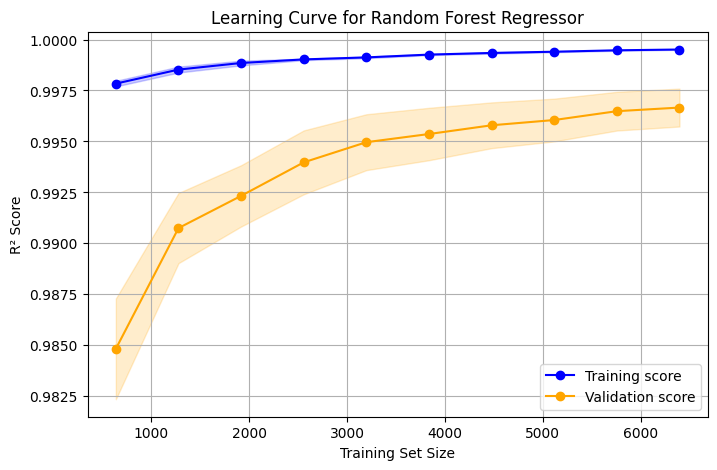

In [24]:
# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_train, y_train,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

# Compute mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, val_mean, 'o-', color='orange', label='Validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='orange')
plt.title("Learning Curve for Random Forest Regressor")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend()
plt.grid(True)
plt.show()

The learning curve for the Random Forest model shows a consistently high training R² score (~0.999) and a steadily improving validation R² score (~0.995) as the training set size increases. The small gap between the two curves indicates that the model generalizes well to unseen data, with minimal overfitting. Both curves plateau near the top, suggesting that adding more training data would only yield marginal improvements. Overall, the Random Forest model demonstrates strong performance and stability, confirming it as a reliable choice for predicting property sale prices.

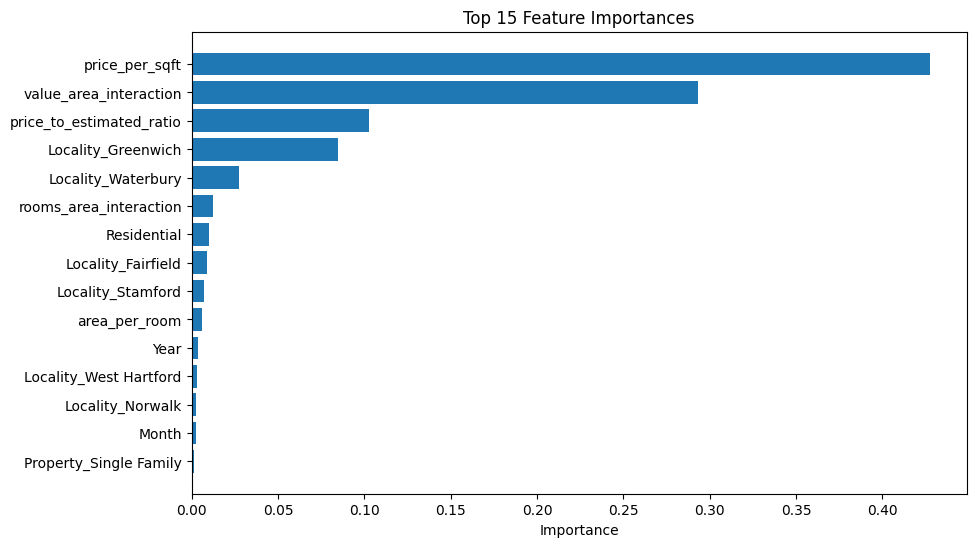

In [31]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# Deep learning models

In [27]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
# Build neural network
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [34]:
# Train with early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

In [35]:
# Evaluate
y_pred_nn = model.predict(X_test_scaled)
print("Neural Network R²:", r2_score(y_test, y_pred_nn))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Neural Network R²: 0.9917507479861435
